In [1]:
# import statements
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import pingouin as pg
from statsmodels.tsa.stattools import acf
import toolbox

# set color bar
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255),
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Load RO data

In [2]:
# load zonal mean temperature data and the tropopause
zm_temp = xr.open_dataset('/home/disk/p/aodhan/GNSSTrends/Data/GNSS_Gridded_ZonalMean_7.5_20230601.nc')
lrz = np.load('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/lrz_maps_zm_annual_mean.npy')

# get array of just temperature
zm_temp_array = zm_temp.temperature.values[:,:,:,0]
copy = zm_temp_array[0]
copy[:] = np.nan

# pad data at the beginning and end of record with nans so we have a full 23 years
nans_beginning = np.broadcast_to([copy], (4,201,24))
nans_end = np.broadcast_to([copy], (8,201,24))
zm_temp_array_with_nans = np.concatenate([nans_beginning, zm_temp_array, nans_end], axis=0)

# find climatology and anomalies
temperature_calendar = np.reshape(zm_temp_array_with_nans, (23,12,201,24))[1:-1] #this trims first and last year of data which are not complete
temperature_anomalies = temperature_calendar - np.nanmean(temperature_calendar, axis=0) # remove seasonality
temperature_anomalies_ts = np.reshape(temperature_anomalies, (21*12, temperature_anomalies.shape[2], temperature_anomalies.shape[3]))

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


## Remove QBO and ENSO and Find Trends

In [3]:
# load ENSO and QBO indices
enso = pd.read_csv('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/meiv2_adjusted.data', sep="    ", header=None)
enso_calendar = [list(enso.iloc[i].values) for i in range(0,len(enso))][22:44]
enso_ts = np.ravel(enso_calendar)[9:-3]
qbo = pd.read_csv('/home/disk/p/aodhan/GNSSTrends/StratTandO3trends/Data/QBO_EOF_coeff.txt', delim_whitespace=True)
qbo = qbo[(qbo['Year'] >= 2002) & (qbo['Year'] <= 2022)]
qbo_eof1 = qbo['EOF-1'].values
qbo_eof2 = qbo['EOF-2'].values

# do MLR regression
temp_anoms_No_QBO_ENSO = toolbox.ENSO_QBO_remover(temperature_anomalies_ts, enso_ts, qbo_eof1, qbo_eof2)

# rearange the array and get trends
temp_anoms_No_QBO_ENSO_sx = np.swapaxes(temp_anoms_No_QBO_ENSO, 0,2)
temp_anoms_No_QBO_ENSO_sxx = np.swapaxes(temp_anoms_No_QBO_ENSO_sx, 1,2)
# get trends
map_of_trends = toolbox.annual_trend_finder(temp_anoms_No_QBO_ENSO_sxx)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


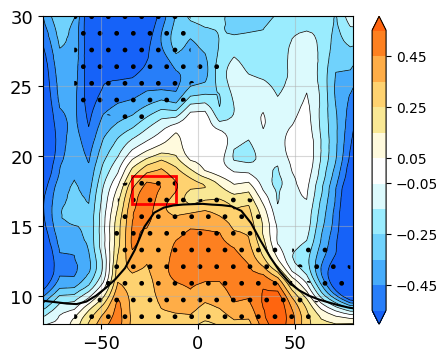

In [4]:
# define contour levels (using same as IPCC figure)
levels = np.arange(-0.55,0.551,.1)

# plot trend contour with colorbar
plt.figure(figsize=(5,4))
plt.contour(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], levels=levels,cmap=custom_cmap, extend='both')
cbar = plt.colorbar()
cbar.set_ticks(np.array([-0.45,-0.25, -0.05, 0.05, 0.25,0.45]))

# add signficance
plt.contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# add lapse-rate tropopause
plt.plot(np.arange(-87.5,87.51,5), lrz, color='black')

# add rectangle patch for AWLS region
rect = patches.Rectangle((-33.75, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)

# set extra plotting parameters
plt.ylim(8,30)
plt.xlim(-80,80)
plt.grid(alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=13)
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROJulDecColorbar.png', dpi=300)

In [5]:
print('AWLS \n==========')
print('Height Red Box: ', zm_temp.alt[83:94].values[0], 'to', zm_temp.alt[83:94].values[-1])
print('Lat Red Box: ', zm_temp.lat[7:11].values[0], 'to', zm_temp.lat[7:11].values[-1])
print('\nAntarctic \n==========')
print('Height Red Box: ', zm_temp.alt[65:86].values[0], 'to', zm_temp.alt[65:86].values[-1])
print('Lat Red Box: ', zm_temp.lat[:4].values[0], 'to', zm_temp.lat[:4].values[-1])
print('\nTropcial \n==========')
print('Height Red Box: ', zm_temp.alt[83:89].values[0], 'to', zm_temp.alt[83:89].values[-1])
print('Lat Red Box: ', zm_temp.lat[9:15].values[0], 'to', zm_temp.lat[9:15].values[-1])


AWLS 
Height Red Box:  16.6 to 18.6
Lat Red Box:  -33.75 to -11.25

Antarctic 
Height Red Box:  13.0 to 17.0
Lat Red Box:  -86.25 to -63.75

Tropcial 
Height Red Box:  16.6 to 17.6
Lat Red Box:  -18.75 to 18.75


In [6]:
# define AWLS ([:, 83-94, 7-11] means [:, 16.6 - 18.6 km, -33.75S - 11.25S]
anomalous_temp_in_box = temp_anoms_No_QBO_ENSO_sxx[:,83:94,7:11]

# get latitude weights and take weighted average
lat_weights = np.cos(np.deg2rad(zm_temp.lat[7:11].values))
anomalous_temp_in_box = np.multiply(anomalous_temp_in_box, lat_weights[np.newaxis, np.newaxis, :])
anomalous_temp_in_box = np.reshape(anomalous_temp_in_box, (len(anomalous_temp_in_box), 11*4))
anomalous_temp_in_box = np.nansum(anomalous_temp_in_box, axis=1)/(np.sum(lat_weights)*11)
#np.save('/home/disk/p/aodhan/GNSSTrends/Data/AWLS', anomalous_temp_in_box)

# get correlations
correlation_map, significance_map = toolbox.annual_corr_finder(temp_anoms_No_QBO_ENSO_sxx, 
                                                               anomalous_temp_in_box)

## Plot Correlation

(-80, 80)

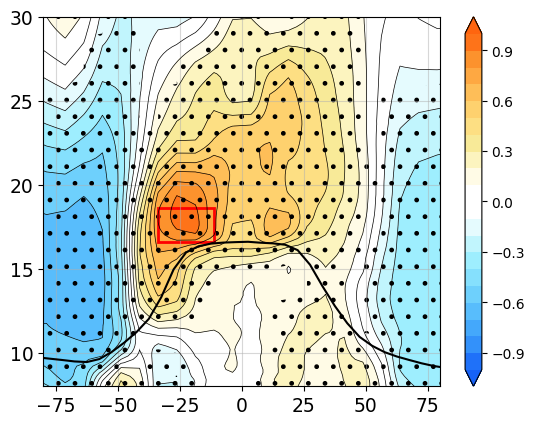

In [7]:
# set contour levels
levels = np.arange(-1,1.01,.1)

# plot correlation with colorbar
plt.contour(zm_temp.lat, zm_temp.alt, correlation_map.T, levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.contourf(zm_temp.lat, zm_temp.alt, correlation_map.T, levels=levels, cmap=custom_cmap, extend='both')
plt.colorbar()

# add significance
plt.contourf(zm_temp.lat, zm_temp.alt, significance_map.T, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# add lapse rate tropopause
plt.plot(np.arange(-87.5,87.51,5), lrz, color='black')

# add rectangle for AWLS region
rect = patches.Rectangle((-33.75, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)

# set tick params
plt.tick_params(axis='both', which='major', labelsize=13.5)
y_vals = np.array([10, 15, 20, 25, 30])
plt.yticks(y_vals)

# include grid and set range
plt.grid(alpha=0.5)
plt.ylim(8,30)
plt.xlim(-80,80)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/NHBoxCorrelation.png', dpi=300)

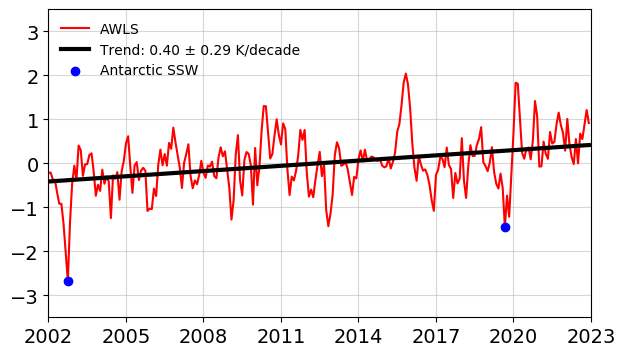

In [9]:
# regress AWLS against time & create trend line
time = np.arange(2002, 2023, 1/12)
lr = stats.linregress(time, anomalous_temp_in_box)
trend_line = lr[1] + lr[0]*time

# find residuals from trend line
residuals = anomalous_temp_in_box - (lr[0] * time + lr[1])

# find degrees of freedom with autocorrelation
rho = acf(residuals, nlags=1)[1] 
n_eff = len(time) * (1 - rho) / (1 + rho)
adjusted_std_err = lr[4] * np.sqrt(len(time) / n_eff)
adjusted_std_err = adjusted_std_err * 1.96 # get 2-sigma confidence
trend_label = f"Trend: {lr[0]*10:.2f} ± {adjusted_std_err*10:.2f} K/decade"

# plot AWLS and trend
fig, axs = plt.subplots(1,1, figsize=(7,4))
plt.plot(time, anomalous_temp_in_box, color='red', label='AWLS')
plt.plot(time, trend_line, color='black', linewidth=3, label=trend_label)

# put Antarctic SSWs on plot
plt.scatter(time[9], anomalous_temp_in_box[9], color='blue', label='Antarctic SSW',zorder=5)
plt.scatter(time[8+(17*12)], anomalous_temp_in_box[8+(17*12)], color='blue',zorder=5)

# set x-ticks
plt.tick_params(axis='both', which='major', labelsize=14)
x_vals = np.arange(2002,2024,3)
axs.set_xticks(x_vals)
axs.set_xticklabels([str(year) for year in x_vals])

# include grid and set range
plt.xlim(2002,2023)
plt.ylim(-3.5,3.5)
plt.grid(alpha=0.5)
plt.legend(frameon=False, loc=0)


#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/AWLSTimeseries', dpi=300)

In [11]:
"""def MLR_map(temperature_anomalies_ts, anomalous_temp_in_box):
    map_mlr = []
    map_sig = []
    for height_index in range(np.shape(temperature_anomalies_ts)[1]):
        mlr_by_lat = []
        sig_by_lat = []
        for lat_index in range(np.shape(temperature_anomalies_ts)[2]):
            temp_ts = temperature_anomalies_ts[:,height_index, lat_index]
            time = np.arange(2002, 2023, 1/12)/10
            
            # find non nan values
            temp_non_nans = temp_ts[~np.isnan(temp_ts)]
            time_non_nans = time[~np.isnan(temp_ts)]
        
            try:        
                temp_detrend = detrender(time_non_nans, temp_non_nans)
                temp_in_box_detrend = detrender(time_non_nans, anomalous_temp_in_box)
                circ_proj = stats.linregress(temp_in_box_detrend, temp_detrend)

                 # fit trend
                reg_coef = circ_proj[0]
                temp_linear_trend = circ_proj[1] + reg_coef*temp_in_box_detrend
                errors = temp_detrend - temp_linear_trend
                time_errors = temp_in_box_detrend - np.nanmean(temp_in_box_detrend)


                # find degrees of freedom with autocorrelation
                N = len(temp_detrend)
                r1_autocorrelation = stats.pearsonr(temp_detrend[1:], temp_detrend[:-1])[0]
                N_star = N*((1-r1_autocorrelation)/
                            (1+r1_autocorrelation))
        
                # find squared error in x and y
                sum_squared_error_res = np.sum(np.square(errors))
                var_errors = (1/N_star)*sum_squared_error_res
                time_squared_error = np.sum(np.square(time_errors))

                simga_slope_squared = var_errors/time_squared_error
                sa = np.sqrt(simga_slope_squared)
                t_stat_calculated = reg_coef/sa

                # get critical t value
                tcrit = stats.t.ppf(1-0.025, N_star)


                if np.abs(t_stat_calculated) > tcrit:
                    significance = 1
                else:
                    significance = 0


                circ_recreation = circ_proj[1] + circ_proj[0]*anomalous_temp_in_box
                mlr_by_lat.append(circ_recreation)
                sig_by_lat.append(significance)
            except:
                mlr_by_lat.append(np.repeat(np.nan, 252))
                sig_by_lat.append(0)
        
        map_mlr.append(mlr_by_lat)
        map_sig.append(sig_by_lat)
    return(np.array(map_mlr), np.array(map_sig))"""

# do circulation projection
projection_timeseries, map_sig = toolbox.annual_circ_regr(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box)
projection_timeseries = np.swapaxes(projection_timeseries, 0,2)
projection_timeseries = np.swapaxes(projection_timeseries, 1,2)
residual = temp_anoms_No_QBO_ENSO_sxx - projection_timeseries

#find trends
map_of_trends = toolbox.annual_trend_finder(temp_anoms_No_QBO_ENSO_sxx)
map_of_trends_projection = toolbox.annual_trend_finder(projection_timeseries)
map_of_trends_residual = toolbox.annual_trend_finder(residual)


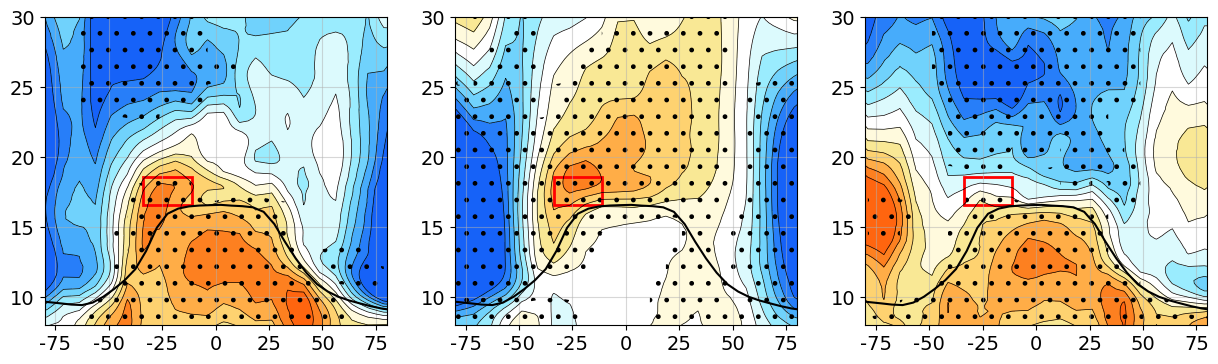

In [13]:
# set contour levels
levels = np.arange(-0.55,0.551,.1)

# define subplots
fig, axs = plt.subplots(1,3, figsize=(15,4))

# plot trends
axs[0].contour(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
axs[0].contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,0], levels=levels,cmap=custom_cmap, extend='both')
axs[0].contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# circulation regression
axs[1].contour(zm_temp.lat, zm_temp.alt, map_of_trends_projection[:,:,0], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
axs[1].contourf(zm_temp.lat, zm_temp.alt, map_of_trends_projection[:,:,0], levels=levels, cmap=custom_cmap, extend='both')
axs[1].contourf(zm_temp.lat, zm_temp.alt, map_sig, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])

# residual
axs[2].contour(zm_temp.lat, zm_temp.alt, map_of_trends_residual[:,:,0], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
axs[2].contourf(zm_temp.lat, zm_temp.alt, map_of_trends_residual[:,:,0], levels=levels,cmap=custom_cmap, extend='both')
axs[2].contourf(zm_temp.lat, zm_temp.alt, map_of_trends_residual[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])


# for each subplot, fix plotting range, include lrz, etc...
for i in range(3):
    axs[i].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    rect = patches.Rectangle((-33.72, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
    axs[i].add_patch(rect)
    axs[i].set_ylim(8,30)
    axs[i].set_xlim(-80,80)
    #axs[i].set_title(titles[i])
    axs[i].grid(alpha=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    x_vals = [-75, -50, -25, 0, 25, 50, 75]
    axs[i].set_xticks(x_vals)
    axs[i].set_xticklabels([str(year) for year in x_vals])

    
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCirculationRegression_SAM', dpi=300)

# Get Seasonal Variation

In [10]:
def seasonal_trend_finder(time_non_nans, temp_non_nans):
    # find residual timeseries
    trend = stats.linregress(time_non_nans, temp_non_nans)
    temp_trend = trend[0]
    temp_linear_trend = trend[1] + temp_trend*time_non_nans
    errors = temp_non_nans - temp_linear_trend
    time_errors = time_non_nans - np.nanmean(time_non_nans)


    # find degrees of freedom with autocorrelation
    N = len(temp_non_nans)
    r1_autocorrelation = stats.pearsonr(temp_non_nans[1:], temp_non_nans[:-1])[0]
    N_star = N*((1-r1_autocorrelation)/
                (1+r1_autocorrelation))

    # find squared error in x and y
    sum_squared_error_res = np.sum(np.square(errors))
    var_errors = (1/N_star)*sum_squared_error_res
    time_squared_error = np.sum(np.square(time_errors))
    simga_slope_squared = var_errors/time_squared_error
    sa = np.sqrt(simga_slope_squared)
    t_stat_calculated = temp_trend/sa

    # get critical t value
    tcrit = stats.t.ppf(1-0.025, N_star)
    if np.abs(t_stat_calculated) > tcrit:
        significance = 1
    else:
        significance = 0
    return([temp_trend, significance])

def MLR_map_season(temperature_anomalies_ts, enso_ts_, qbo_eof1_, qbo_eof2_, anomalous_temp_in_box_, s1, s2, s3):
    resid_map = []
    map_mlr = []
    for height_index in range(np.shape(temperature_anomalies_ts)[1]):
        mlr_by_lat = []
        for lat_index in range(np.shape(temperature_anomalies_ts)[2]):
            
            temp_ts = temperature_anomalies_ts[:,height_index, lat_index]
            time = np.arange(2002, 2023, 1/12)/10

            time_cal = np.reshape(time, (21,12))
            temp_cal = np.reshape(temp_ts, (21,12))
            qbo1_cal = np.reshape(qbo_eof1_, (21,12))
            qbo2_cal = np.reshape(qbo_eof2_, (21,12))
            enso_cal = np.reshape(enso_ts_, (21,12))
            anomalous_temp_in_box_cal = np.reshape(anomalous_temp_in_box_, (21,12))

            time = np.transpose([time_cal[:,s1], time_cal[:,s2], time_cal[:,s3]]).ravel()
            temp_ts = np.transpose([temp_cal[:,s1], temp_cal[:,s2], temp_cal[:,s3]]).ravel()
            qbo_eof1 = np.transpose([qbo1_cal[:,s1], qbo1_cal[:,s2], qbo1_cal[:,s3]]).ravel()
            qbo_eof2 = np.transpose([qbo2_cal[:,s1], qbo2_cal[:,s2], qbo2_cal[:,s3]]).ravel()
            enso_ts = np.transpose([enso_cal[:,s1], enso_cal[:,s2], enso_cal[:,s3]]).ravel()
            anomalous_temp_in_box = np.transpose([anomalous_temp_in_box_cal[:,s1], 
                                                  anomalous_temp_in_box_cal[:,s2], 
                                                  anomalous_temp_in_box_cal[:,s3]]).ravel()


            # find non nan values
            temp_non_nans = temp_ts[~np.isnan(temp_ts)]
            time_non_nans = time[~np.isnan(temp_ts)]
            qbo_eof1_non_nans = qbo_eof1[~np.isnan(temp_ts)]
            qbo_eof2_non_nans = qbo_eof2[~np.isnan(temp_ts)]
            enso_non_nans = enso_ts[~np.isnan(temp_ts)]
            anomalous_temp_in_box = anomalous_temp_in_box[~np.isnan(temp_ts)]

            # data df 
            predictors_and_target = [qbo_eof1_non_nans, qbo_eof2_non_nans, enso_non_nans, temp_non_nans]
            df = pd.DataFrame(np.transpose(predictors_and_target), columns=['qbo1', 'qbo2', 'enso', 'temp'])
            
            
            
            try:
                Preds = df[['qbo1', 'qbo2', 'enso']]
                Target = df['temp']
                lm = pg.linear_regression(Preds, Target)

                # get coefficients of regression
                Intercept = lm.coef[0]
                qbo1 = lm.coef[1]
                qbo2 = lm.coef[2]
                enso = lm.coef[3]

                #remove qbo and enso
                recreation = Intercept + qbo1*qbo_eof1_non_nans + qbo2*qbo_eof2_non_nans + enso_non_nans*enso
                temp_res = temp_non_nans - recreation

                # get raw trend
                raw_trend_sig = seasonal_trend_finder(time_non_nans, temp_res)

                # get circulation trend
                temp_res_detrend = detrender(time_non_nans, temp_res)
                temp_in_box_detrend = detrender(time_non_nans, anomalous_temp_in_box)
                corr = stats.pearsonr(temp_res_detrend, temp_in_box_detrend)[0]
                circ_proj = stats.linregress(temp_in_box_detrend, temp_res_detrend)
                circ_recreation = circ_proj[1] + circ_proj[0]*anomalous_temp_in_box
                circ_trend = stats.linregress(time_non_nans, circ_recreation)[0]
                _, circ_significance = seasonal_trend_finder(temp_in_box_detrend, temp_res_detrend)
                circ_trend_sig = [circ_trend, circ_significance]

                # get residual trend
                residual = temp_res - circ_recreation
                res_trend_sig = seasonal_trend_finder(time_non_nans, residual)

                #raw_trend_sig[0] = corr
                #raw_trend_sig[0] = stats.linregress(temp_in_box_detrend, temp_res_detrend)[0]
                # get N-samples and correlation coefficient
                #N = len(temp_res_detrend)
                #r = stats.pearsonr(temp_res_detrend, temp_in_box_detrend)[0]
                # find significance based on correlation (and auto-correlation)
                #r1_autocorrelation = stats.pearsonr(temp_res_detrend[1:], temp_res_detrend[:-1])[0]
                #r2_autocorrelation = stats.pearsonr(temp_in_box_detrend[1:], temp_in_box_detrend[:-1])[0]
                #N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                #            (1+r1_autocorrelation*r2_autocorrelation))
                #tcrit = stats.t.ppf(1-0.025, N_star)
                #t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
                #if abs(t) - tcrit > 0:
                #    significant = 1
                #else:
                #    significant = 0
                #raw_trend_sig[1] = significant

                mlr_by_lat.append([raw_trend_sig, circ_trend_sig, res_trend_sig])
            except:
                nan_trend_sig = [np.NaN, np.NaN]
                mlr_by_lat.append([nan_trend_sig, nan_trend_sig, nan_trend_sig])
        map_mlr.append(mlr_by_lat)
    return(np.array(map_mlr))


DJF  = MLR_map_season(temperature_anomalies_ts, enso_ts, qbo_eof1, qbo_eof2, anomalous_temp_in_box, 0,1,11)
MAM  = MLR_map_season(temperature_anomalies_ts, enso_ts, qbo_eof1, qbo_eof2, anomalous_temp_in_box, 2,3,4)
JJA  = MLR_map_season(temperature_anomalies_ts, enso_ts, qbo_eof1, qbo_eof2, anomalous_temp_in_box, 5,6,7)
SON  = MLR_map_season(temperature_anomalies_ts, enso_ts, qbo_eof1, qbo_eof2, anomalous_temp_in_box, 8,9,10)
seasons = [DJF, MAM, JJA, SON]


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pingouin/regression.py:410: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 3 with 4 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn('Design matrix supplied with `X` parameter is rank '
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pingouin/regression.py:435: RuntimeWarning: invalid value encountered in double_scalars
  adj_r2 = 1 - (1 - r2) * (n - constant) / df_resid
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/pingouin/regression.py:438: RuntimeWarning: divide by zero encountered in double_scalars
  mse = ss_res / df_resid
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero e

In [11]:
np.shape(map_of_trends)

(201, 24, 2)

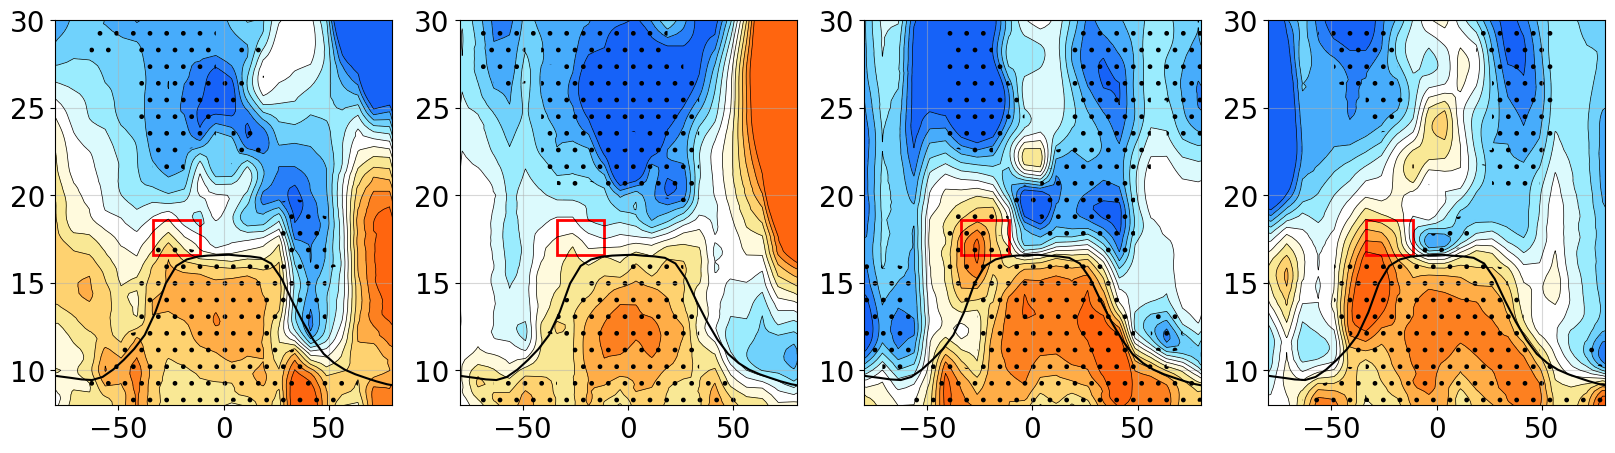

In [12]:
titles = ['DJF', 'MAM', 'JJA', 'SON']

levels = np.arange(-0.55, 0.551,.1)
fig, axs = plt.subplots(1,4, figsize=(20,5))
axes = axs.ravel()
for x in range(len(seasons)):
    axes[x].contour(zm_temp.lat, zm_temp.alt, seasons[x][:,:,2,0], levels=levels, colors='black', 
                    extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    im = axes[x].contourf(zm_temp.lat, zm_temp.alt,  seasons[x][:,:,2,0], levels=levels,cmap=custom_cmap, extend='both')
    axes[x].contourf(zm_temp.lat, zm_temp.alt, seasons[x][:,:,2,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axes[x].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    rect = patches.Rectangle((-33.75, 16.6), 22.5, 2, linewidth=2, edgecolor='red', facecolor='none')
    axes[x].add_patch(rect)
    axes[x].set_ylim(8,30)
    axes[x].set_xlim(-80,80)
    axes[x].grid(alpha=0.5)
    axes[x].tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/RODifferenceSeason', dpi=300)

# Get Monthly Variation

In [13]:
def MLR_map_month(temperature_anomalies_ts, anomalous_temp_in_box_, s1):
    resid_map = []
    map_mlr = []
    for height_index in range(np.shape(temperature_anomalies_ts)[1]):
        mlr_by_lat = []
        for lat_index in range(np.shape(temperature_anomalies_ts)[2]):
            
            # select timeseries
            temp_ts = temperature_anomalies_ts[:,height_index, lat_index]
            
            # create time and calendars
            time = np.arange(2002, 2023, 1/12)/10
            time_cal = np.reshape(time, (21,12))
            temp_cal = np.reshape(temp_ts, (21,12))
            anomalous_temp_in_box_cal = np.reshape(anomalous_temp_in_box_, (21,12))

            # create seasonal timeseries
            time = np.transpose([time_cal[:,s1]]).ravel()
            temp_ts = np.transpose([temp_cal[:,s1]]).ravel()
            anomalous_temp_in_box = np.transpose([anomalous_temp_in_box_cal[:,s1]]).ravel()

            # find non nan values
            temp_non_nans = temp_ts[~np.isnan(temp_ts)]
            time_non_nans = time[~np.isnan(temp_ts)]
            anomalous_temp_in_box = anomalous_temp_in_box[~np.isnan(temp_ts)]

            
            try:
                temp_res = temp_non_nans 
                anomalous_temp_in_box = anomalous_temp_in_box 
                
                # get raw trend
                raw_trend_sig = seasonal_trend_finder(time_non_nans, temp_non_nans)
                
                # get circulation trend
                #######################################################
                # first detrend data
                temp_non_nans_detrend = detrender(time_non_nans, temp_non_nans)
                temp_in_box_detrend = detrender(time_non_nans, anomalous_temp_in_box)
        
                # then get projection and circulation
                circ_proj = stats.linregress(temp_in_box_detrend, temp_non_nans_detrend)
                circ_recreation = circ_proj[1] + circ_proj[0]*anomalous_temp_in_box
                circ_trend = stats.linregress(time_non_nans, circ_recreation)[0]
                _, circ_significance = seasonal_trend_finder(temp_in_box_detrend, temp_non_nans_detrend)
                circ_trend_sig = [circ_trend, circ_significance]
                #######################################################
                
                # get residual trend
                residual = temp_non_nans - circ_recreation
                res_trend_sig = seasonal_trend_finder(time_non_nans, residual)
                
                # append to mlr
                mlr_by_lat.append([raw_trend_sig, circ_trend_sig, res_trend_sig])
            except:
                
                # create nan array
                nan_trend_sig = [np.NaN, np.NaN]
                
                # append nans
                mlr_by_lat.append([nan_trend_sig, nan_trend_sig, nan_trend_sig])
        map_mlr.append(mlr_by_lat)
    return(np.array(map_mlr))


jan  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 0)
feb  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 1)
mar  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 2)
apr  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 3)
may  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 4)
jun  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 5)
jul  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 6)
aug  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 7)
sep  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 8)
occ  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 9)
nov  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 10)
dec  = MLR_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 11)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stde

IndexError: too many indices for array

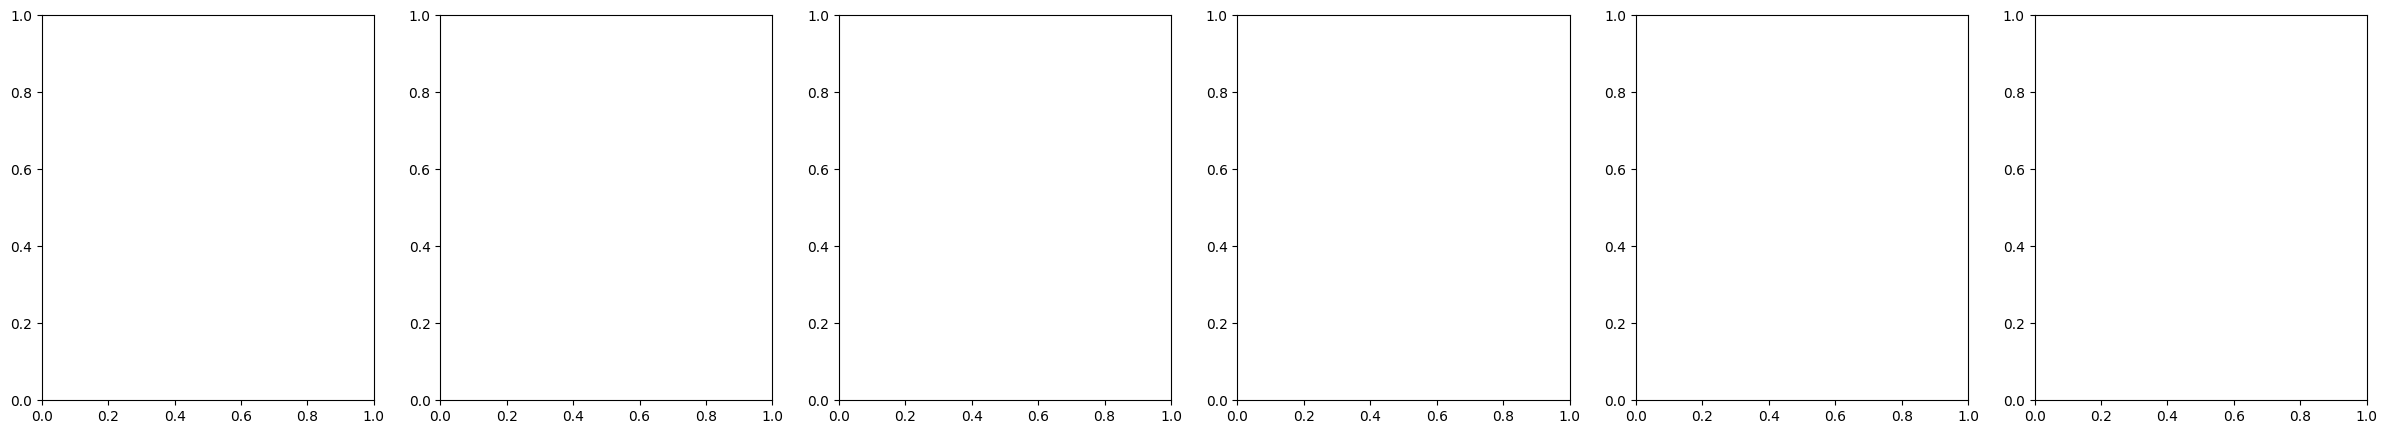

In [17]:
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

levels = np.arange(-0.55, 0.551,.1)*2
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()
for x in range(len(months1)):
    axes[x].contour(zm_temp.lat, zm_temp.alt, months2[x][:,:,2,0], levels=levels,colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(zm_temp.lat, zm_temp.alt,  months2[x][:,:,2,0], levels=levels,cmap=custom_cmap, extend='both')
    axes[x].contourf(zm_temp.lat, zm_temp.alt, months2[x][:,:,2,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axes[x].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    rect = patches.Rectangle((-18.75, 16.6), 37.5, 1, linewidth=2, edgecolor='red', facecolor='none')
    axes[x].add_patch(rect)
    axes[x].set_ylim(8,30)
    axes[x].set_xlim(-82,82)
    axes[x].grid(alpha=0.5)
    x_vals = [-60, -30, 0, 30, 60]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    y_vals = [10,15,20,25,30]
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)
    #axes[x].tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

In [15]:
def corr_map_month(temperature_anomalies_ts, anomalous_temp_in_box_, s1):
    r_map = []
    for height_index in range(np.shape(temperature_anomalies_ts)[1]):
        r_by_lat = []
        for lat_index in range(np.shape(temperature_anomalies_ts)[2]):
            
            # select timeseries
            temp_ts = temperature_anomalies_ts[:,height_index, lat_index]
            
            # create time and calendars
            time = np.arange(2002, 2023, 1/12)/10
            time_cal = np.reshape(time, (21,12))
            temp_cal = np.reshape(temp_ts, (21,12))
            anomalous_temp_in_box_cal = np.reshape(anomalous_temp_in_box_, (21,12))

            # create seasonal timeseries
            time = np.transpose([time_cal[:,s1]]).ravel()
            temp_ts = np.transpose([temp_cal[:,s1]]).ravel()
            anomalous_temp_in_box = np.transpose([anomalous_temp_in_box_cal[:,s1]]).ravel()

            # find non nan values
            temp_non_nans = temp_ts[~np.isnan(temp_ts)]
            time_non_nans = time[~np.isnan(temp_ts)]
            anomalous_temp_in_box = anomalous_temp_in_box[~np.isnan(temp_ts)]

            try:
                temp_res = temp_non_nans 
                anomalous_temp_in_box = anomalous_temp_in_box 

                # get raw trend
                raw_trend_sig = seasonal_trend_finder(time_non_nans, temp_non_nans)

                # get correlations for month trend
                #######################################################
                # detrend the data for correlation so that you don't inflate correlation
                temp_non_nans_detrend = detrender(time_non_nans, temp_non_nans)
                temp_in_box_detrend = detrender(time_non_nans, anomalous_temp_in_box)

                # get N-samples and correlation coefficient
                N = len(temp_non_nans_detrend)
                r = stats.pearsonr(temp_non_nans_detrend, temp_in_box_detrend)[0]

                # find significance based on correlation (and auto-correlation)
                r1_autocorrelation = stats.pearsonr(temp_non_nans_detrend[1:], temp_non_nans_detrend[:-1])[0]
                r2_autocorrelation = stats.pearsonr(temp_in_box_detrend[1:], temp_in_box_detrend[:-1])[0]
                N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                            (1+r1_autocorrelation*r2_autocorrelation))

                tcrit = stats.t.ppf(1-0.025, N_star)
                t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))


                if abs(t) - tcrit > 0:
                    significant = 1
                else:
                    significant = 0
                #######################################################

                # append to mlr
                r_by_lat.append([r, significant])
            except:
            
                # create and append nan array
                r_by_lat.append([np.NaN, np.NaN])
                
        r_map.append(r_by_lat)
    return(np.array(r_map))


jan  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 0)
feb  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 1)
mar  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 2)
apr  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 3)
may  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 4)
jun  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 5)
jul  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 6)
aug  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 7)
sep  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 8)
occ  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 9)
nov  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 10)
dec  = corr_map_month(temp_anoms_No_QBO_ENSO_sxx, anomalous_temp_in_box, 11)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


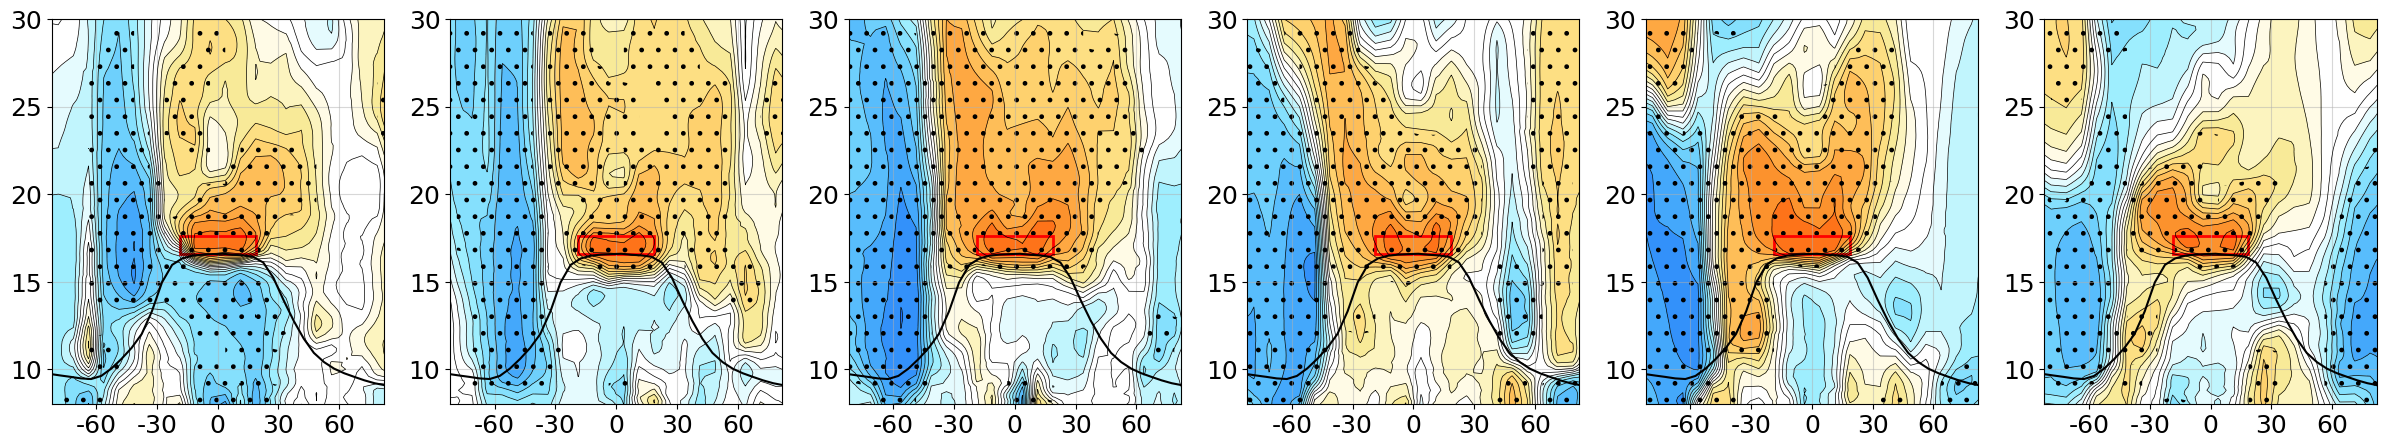

In [21]:
months1 = [jan, feb, mar, apr, may, jun]
months2 = [jul, aug, sep, occ, nov, dec]

levels = np.arange(-1,1.01,.1)
fig, axs = plt.subplots(1,6, figsize=(30,5))
axes = axs.ravel()
for x in range(len(months1)):
    axes[x].contour(zm_temp.lat, zm_temp.alt, months2[x][:,:,0], levels=levels,colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(zm_temp.lat, zm_temp.alt,  months2[x][:,:,0], levels=levels,cmap=custom_cmap, extend='both')
    axes[x].contourf(zm_temp.lat, zm_temp.alt, months2[x][:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axes[x].plot(np.arange(-87.5,87.51,5), lrz, color='black')
    rect = patches.Rectangle((-18.75, 16.6), 37.5, 1, linewidth=2, edgecolor='red', facecolor='none')
    axes[x].add_patch(rect)
    axes[x].set_ylim(8,30)
    axes[x].set_xlim(-82,82)
    axes[x].grid(alpha=0.5)
    x_vals = [-60, -30, 0, 30, 60]
    axes[x].set_xticks(x_vals)
    axes[x].set_xticklabels([str(year) for year in x_vals])
    y_vals = [10,15,20,25,30]
    axes[x].set_yticks(y_vals)
    axes[x].set_yticklabels([str(year) for year in y_vals])
    axes[x].tick_params(axis='both', which='major', labelsize=18)
    #axes[x].tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/ROCircRegrJanJun', dpi=300)

# Find EOFS


In [304]:
def detrender(temp_anoms):
    time = np.arange(2002 + 1/12, 2023, 1/12)/10
    grid = []
    for x in range(0, len(temp_anoms[0])):
        lat_line = []
        for y in range(0, len(temp_anoms[0][0])):
            ts = temp_anoms[:,x,y]
            regression = stats.linregress(time, ts)
            slope = regression[0]
            intercept = regression[1]
            recreation = intercept + slope*time
            ts_detrended = ts - recreation
            lat_line.append(ts_detrended)
        grid.append(lat_line)
    grid = np.swapaxes(grid, 0,2)
    grid = np.swapaxes(grid, 1,2)
    return(grid)

#find dimensions of data
lats = zm_temp.lat.values[1:-1]
alts = zm_temp.alt.values[40:151]
pres = 1000*np.exp(-1*alts/7)


In [125]:
# find weights for lats and pressures
lat_weights = np.sqrt(np.cos(np.deg2rad(lats)))
pres_weights = np.sqrt(1.255*np.exp(-1*alts/7))
#pres_weights[:] = 1

# weight data
temp_anoms = temp_anoms_No_QBO_ENSO_sxx[:,40:151,1:-1]
#temp_anoms = detrender(temp_anoms)
temp_anoms_pres_weight = np.multiply(temp_anoms, pres_weights[np.newaxis,:,np.newaxis])
temp_anoms_weighted = np.multiply(temp_anoms_pres_weight, lat_weights[np.newaxis,np.newaxis,:])

# structure x sample
shape = np.shape(temp_anoms_weighted)
sample_x_structure = temp_anoms_weighted.reshape(shape[0], shape[1]*shape[2])
structure_x_sample = np.transpose(sample_x_structure)

u, s, vh = np.linalg.svd(structure_x_sample, full_matrices=True)
eofs = u.T

In [126]:
temp_anoms = temp_anoms_No_QBO_ENSO_sxx[:,40:151,1:-1]
#temp_anoms = detrender(temp_anoms)
temp_anoms_pres_weight = np.multiply(temp_anoms, pres_weights[np.newaxis,:,np.newaxis])
temp_anoms_weighted = np.multiply(temp_anoms_pres_weight, lat_weights[np.newaxis,np.newaxis,:])


In [127]:
u, s, vh = np.linalg.svd(structure_x_sample, full_matrices=True)
eofs = u.T

smat = np.zeros(np.shape(structure_x_sample), dtype=complex)
smat[:252, :252] = np.diag(s)

#create eofs with correct amplitude
D = np.matmul(u, smat)/(np.sqrt(120))
corrected_amplitude_eof = D.T
eofs = corrected_amplitude_eof.reshape(shape)

#find Principal Components
pcs = np.matmul(smat, vh).real

Text(0, 0.5, '% Explained Variance')

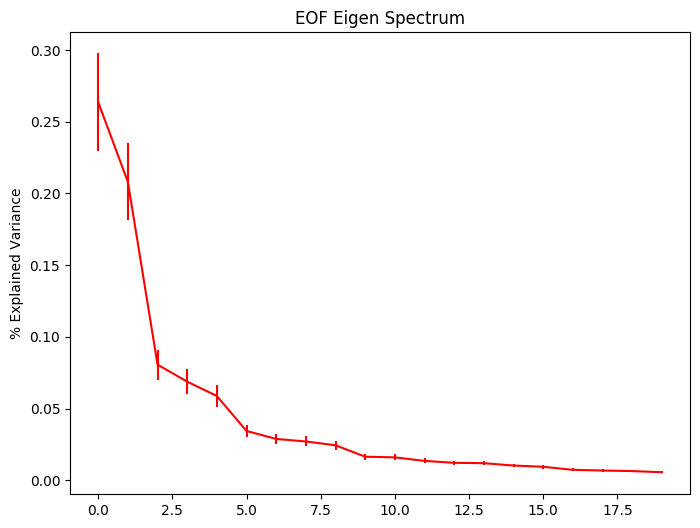

In [128]:
#Find Eigenvalues and Use north test to find if significant
eigenvalues = (np.multiply(s,s))/len(s)
eigenvalues_as_frac_of_cov = eigenvalues/(np.sum(eigenvalues))
error_bars = eigenvalues_as_frac_of_cov*np.sqrt(2/120)

plt.figure(figsize=(8, 6))
plt.errorbar(x=range(0,20), y=eigenvalues_as_frac_of_cov[:20], yerr=error_bars[:20], color='red')
plt.title('EOF Eigen Spectrum')
plt.ylabel('% Explained Variance')
#plt.savefig('CF_EOF_eigenspectrum')

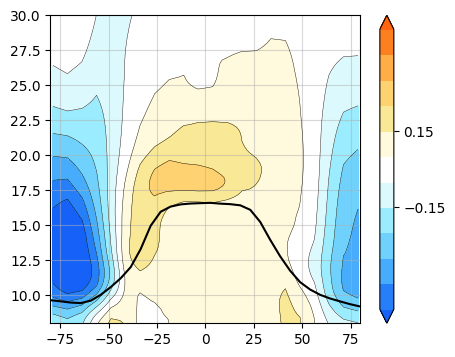

In [133]:
levels = np.arange(-0.55, 0.551, 0.1)*1

fig, axs = plt.subplots(1,1, figsize=(5,4))
for i in range(0, len([axs])):
    #eof_unweight = np.divide(eofs[0], pres_weights[:,np.newaxis])
    eof_unweight = eofs[0]#np.divide(eof_unweight, lat_weights[np.newaxis,:])
    axs.contour(lats, alts, eof_unweight, levels=levels, colors='black', extend='both', linewidths=0.3, linestyles=np.where(levels >= 0, "-", "-"))
    im = axs.contourf(lats, alts, eof_unweight, levels=levels, cmap=custom_cmap, extend='both')
    axs.plot(np.linspace(-90,90,36), lrz, color='black')
    #axs.set_title('RO Detrended Interannual \nEOF 1   ' + str(eigenvalues_as_frac_of_cov[0]*100)[:4] + '%')
    axs.set_xlim(-80,80)
    axs.set_ylim(8,30)
    axs.grid(alpha=0.5)
    cbar = plt.colorbar(im)
    rect = patches.Rectangle((-33.75, 16), 15, 2, linewidth=2, edgecolor='red', facecolor='none')
    #axs.add_patch(rect)
cbar.set_ticks(np.array([-0.45,-0.25, -0.05, 0.05, 0.25,0.45])*3)


In [134]:
np.save('/home/disk/p/aodhan/GNSSTrends/Data/PC1_RO_Temp_NoDetrend.npy', pcs[0])


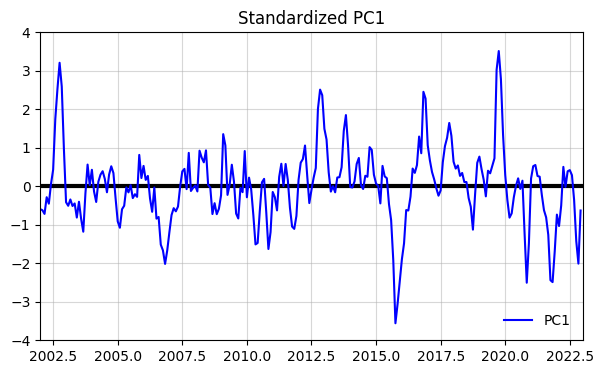

In [223]:
fig = plt.figure(figsize=(7,4))
time_1 = np.arange(2002, 2023, 1/12)
pc = pcs[0]
pc = pc/np.nanstd(pc)
lr = stats.linregress(time_1, pc)
recreation = lr[1] + lr[0]*time_1

plt.plot(time_1, recreation, color='black', linewidth=3)#, label=str(lr[0]*10)[:5] + ' std/decade')
plt.plot(time_1, pc, color='blue', label='PC1')
#plt.plot(time_1, pc2/np.nanstd(pc2), color='blue', label='AWLS Temperature Anomalies')
#plt.plot(time_1, SAM_anoms, color='dodgerblue', label='AWLS Temperature Anomalies')
plt.xlim(2002,2023)
plt.ylim(-4,4)
plt.grid(alpha=0.5)
plt.title('Standardized PC1')
plt.legend(frameon=False, loc=4)

In [212]:
np.shape(temp_anoms_No_QBO_ENSO_sxx)

(252, 201, 24)

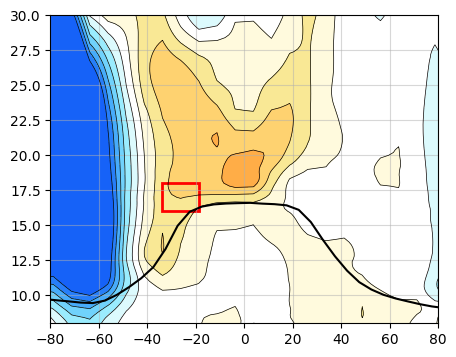

In [52]:
levels = np.arange(-0.55,0.551,.1)*7
plt.figure(figsize=(5,4))
plt.contour(zm_temp.lat, zm_temp.alt, temp_anoms_No_QBO_ENSO_sxx[165], levels=levels, colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
plt.contourf(zm_temp.lat, zm_temp.alt, temp_anoms_No_QBO_ENSO_sxx[165], levels=levels,cmap=custom_cmap, extend='both')
#cbar = plt.colorbar()
#plt.contourf(zm_temp.lat, zm_temp.alt, map_of_trends[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
#cbar.set_ticks([-0.45,-0.25, -0.05, 0.05, 0.25,0.45])
plt.plot(np.arange(-87.5,87.51,5), lrz, color='black')
plt.ylim(8,30)
plt.xlim(-80,80)
rect = patches.Rectangle((-33.75, 16), 15, 2, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)
plt.grid(alpha=0.5)
#plt.title('Temperature Trends (2002-2022)')

In [53]:
print(np.linspace(2002,2023, 252)[165])

2015.804780876494


In [69]:
xr.open_dataset('/home/disk/p/aodhan/GNSSTrends/TrendAnalysis/Dong_et-al_2019_Greens_Function.nc')

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    TOA      (lat, lon) float64 ...
    CRE      (lat, lon) float64 ...
    CRELW    (lat, lon) float64 ...
    CRESW    (lat, lon) float64 ...
    TAS      (lat, lon) float64 ...
Attributes:
    description:  CAM4 Greens function
    history:      Created Thu Aug 22 12:31:49 2019
    source:       Dong Y, C Proistosescu, KC Armour and DS Battisti (2019)   ...

/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


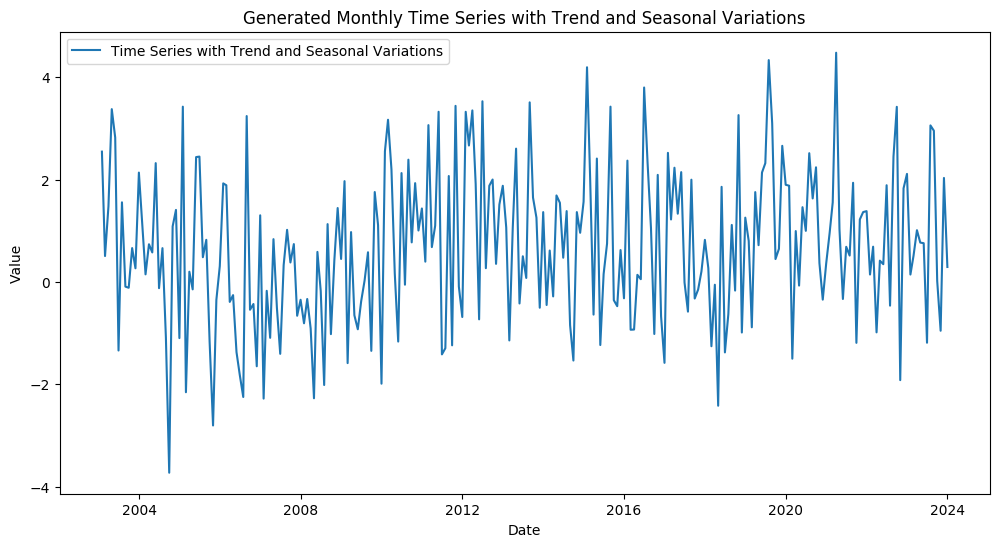

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
np.random.seed(0)  # For reproducibility
n_years = 21
months_per_year = 12
total_months = n_years * months_per_year

# Time index
date_range = pd.date_range(start='2003-01-01', periods=total_months, freq='M')

# Base trend: linear trend
trend_slope = 0.005  # Trend slope per month
base_trend = np.arange(total_months) * trend_slope

# Seasonal trends: different trends for each season
seasonal_trends = {
    'Winter': -0.1,
    'Spring': 0.,
    'Summer': 0.1,
    'Fall': 0.
}

# Define seasonal components
seasonal_components = np.zeros(total_months)
for i in range(total_months):
    month = date_range[i].month
    if month in [12, 1, 2]:  # Winter
        seasonal_components[i] = seasonal_trends['Winter']
    elif month in [3, 4, 5]:  # Spring
        seasonal_components[i] = seasonal_trends['Spring']
    elif month in [6, 7, 8]:  # Summer
        seasonal_components[i] = seasonal_trends['Summer']
    elif month in [9, 10, 11]:  # Fall
        seasonal_components[i] = seasonal_trends['Fall']

# Combine base trend and seasonal components
noise = np.random.normal(scale=1.5, size=total_months)  # Add some random noise
time_series = base_trend + seasonal_components + noise

# Create DataFrame
df = pd.DataFrame({
    'Date': date_range,
    'TimeSeries': time_series
})
df.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['TimeSeries'], label='Time Series with Trend and Seasonal Variations')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Generated Monthly Time Series with Trend and Seasonal Variations')
plt.legend()
plt.show()
data_ts = df.TimeSeries.to_list()

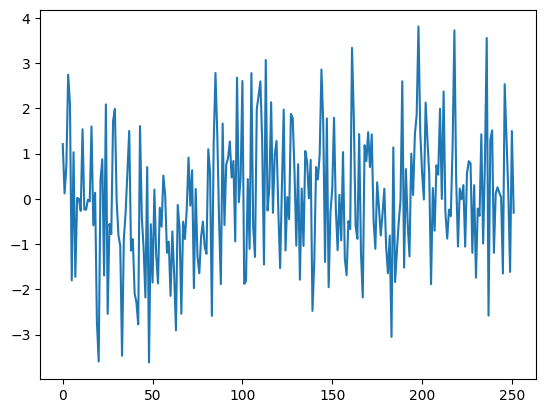

In [203]:
time = np.linspace(2002,2023, 252)/10
calendar = np.reshape(data_ts, (21,12))
seasonality = np.nanmean(calendar, axis=0)
anomaly_calendar = calendar - seasonality
anomaly_ts = anomaly_calendar.ravel()
plt.plot(anomaly_ts)

In [204]:
print('Total Trend', stats.linregress(time, anomaly_ts)[0])
time_cal = np.reshape(time, (21,12))
time_season = np.transpose([time_cal[:,0], time_cal[:,1], time_cal[:,11]]).ravel()
djf = np.transpose([anomaly_calendar[:,0], anomaly_calendar[:,1], anomaly_calendar[:,11]]).ravel()
mam = np.transpose([anomaly_calendar[:,2], anomaly_calendar[:,3], anomaly_calendar[:,4]]).ravel()
jja = np.transpose([anomaly_calendar[:,5], anomaly_calendar[:,6], anomaly_calendar[:,7]]).ravel()
son = np.transpose([anomaly_calendar[:,8], anomaly_calendar[:,9], anomaly_calendar[:,10]]).ravel()
djf_trend = stats.linregress(time_season, djf)[0]
mam_trend = stats.linregress(time_season, mam)[0]
jja_trend = stats.linregress(time_season, jja)[0]
son_trend = stats.linregress(time_season, son)[0]
print(np.nanmean([djf_trend, mam_trend, jja_trend, son_trend]))

Total Trend 0.3763484349547381
0.37544386491344917


In [192]:
print(djf_trend, mam_trend, jja_trend, son_trend)

0.5569001382856033 0.5600651261684854 0.6128791278577821 0.591010430129297


In [42]:
time = np.array([1,2,3,4,5,6,7,8,9,10])
timeseries = np.array([1,3,2,6,3,4,7,1,8,7])

s1 = [1,3,5,7,9]
s2 = [0,2,4,6,8]
stats.linregress(time, timeseries)[0]

0.5333333333333333

In [43]:
trend_1 = stats.pearsonr(time[s1], timeseries[s1])[0]

In [44]:
trend_2 = stats.pearsonr(time[s2], timeseries[s2])[0]

In [45]:
np.nanmean([trend_1, trend_2])

0.5816293552183474

In [47]:
trend_2

0.9645788568769382